### (Bundesliga) game prediction

Simple model for the predictions of soccer games: How many goals a team scores.

As data only the results from prior games are used. 

#### Loading and processing of data 

In [81]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [82]:
# some simple preprocessing of the data
clubs = pd.read_csv("bundesliga_Verein.csv", sep=';' , encoding ='latin1')
del(clubs["Unnamed: 3"])
# for convinience the club id should start with 0
clubs.V_ID = clubs.V_ID - 1
clubs = clubs.set_index("V_ID")
#clubs

In [83]:
top_club_ids = clubs[clubs.Liga==1].index
top_club_ids

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='int64', name=u'V_ID')

In [84]:
games = pd.read_csv("bundesliga_Spiel.csv", sep=';')
del(games["Unnamed: 8"])
# for convinience the club id should start with 0
games.Heim = games.Heim-1
games.Gast = games.Gast-1

In [85]:
top_games = games[games.Heim.isin(top_club_ids)]

In [86]:
#top_games

In [87]:
# todo: automatically 
actual_date = "2015-12-30"
top_games = top_games[games.Datum < actual_date]
len(top_games)

/Users/student/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


153

In [88]:
import pymc
import numpy as np

In [89]:
#c = [[i,j] for i in top_club_ids if i!=j for j in top_club_ids]

In [90]:
def get_toto_results():
    results_ = list()
    toto_result = list()
    for i in top_games.iterrows():
        r = i[1]
        gg = r.Tore_Heim
        ag = r.Tore_Gast
        re = (1 if gg>ag else 2 if gg<ag else 0)
        rr = (1 if gg>ag else -1 if gg<ag else 0)
        toto_result.append((r.Heim, r.Gast, re))
        results_.append((r.Heim, r.Gast, rr))
    return toto_result, results_
toto_results_, results_ = get_toto_results()

In [91]:
def get_goal_results(gh="Tore_Gast"):
    result = list()
    for i in top_games.iterrows():
        r = i[1]
        result.append((r.Heim, r.Gast, r[gh]))
    return result

away_goals_ = get_goal_results("Tore_Gast")
home_goals_ = get_goal_results("Tore_Heim")

In [92]:
#home_goals_

In [93]:

low = 0.0000000001

Idea: The number of goals a team scores can be modeled with a Poisson distribution.

#### Poisson distribution

Probability for outcome $k \in \{0, 1, 2, \dots\}$
 
$$
P_\lambda (k) = \frac{\lambda^k}{k!}\, \mathrm{e}^{-\lambda}
$$

with parameter $\lambda>0$
- $\lambda$ is also the expectation and variance of the distribution

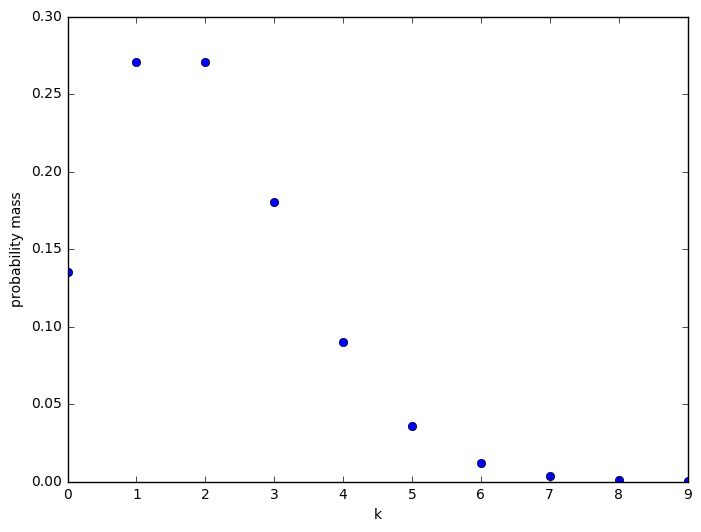

In [94]:
import scipy.stats
k=np.arange(0,10)
lambda_= 2
poisson = scipy.stats.poisson.pmf(k, lambda_)

plt.figure(figsize=(8,6))
plt.plot(k, poisson, 'bo', ms=6, label='poisson pmf')
plt.xlabel("k")
plt.ylabel("probability mass")

#### Probabilistic Model

Each team $i$ has a offence and defence strength (distribution). (Note that the average goals per game $\approx 3 \Rightarrow \Delta \mu=1.5$):

$$
 offence_i \sim \mathcal N(\mu=1.5, \tau=1) 
$$
$$
 defence_i \sim \mathcal N(\mu=0, \tau=1) 
$$

$\mathcal N$ is the Gaussian distribution with parameters 
- mean: $\mu$
- precision: $\tau=1/\sigma^2$ (variance: $\sigma^2$)

Model: The number of goals that team $i$ scores against team $j$ is Poisson distributed with 

$$
 goals_{ij} = Poisson \left(\lambda = (offence_i-defence_j) \right)
$$


In [95]:
import daft
def plot_model():
    pgm = daft.PGM([6.3, 4.05], origin=[-1., -1.], aspect=1.)
    pgm.add_node(daft.Node("mu_o", r"$\mu_o$", .5, .5, fixed=True))
    pgm.add_node(daft.Node("tau_o", r"$\tau_o$", .5, 1.5, fixed=True))    
    pgm.add_node(daft.Node("o_i", r"o$_i$", 1.5, 1))
    
    pgm.add_node(daft.Node("tau_d", r"$\tau_d$", 2., 3., fixed=True))
    pgm.add_node(daft.Node("mu_d", r"$\mu_d$", 3., 3., fixed=True))
    pgm.add_node(daft.Node("d_j", r"d$_j$", 2.5, 2.2))
    
    #pgm.add_node(daft.Node("Delta", r"$\Delta_{ij}$", 2.5, 1))
    pgm.add_node(daft.Node("g", r"g$_{ij}$", 2.5, 1., observed=True))

    
    # Add in the edges.
    pgm.add_edge("mu_o", "o_i")
    pgm.add_edge("tau_o", "o_i")
    pgm.add_edge("mu_d", "d_j")
    pgm.add_edge("tau_d", "d_j")
    pgm.add_edge("o_i", "g")
    pgm.add_edge("d_j", "g")
    #pgm.add_edge("Delta", "g")
    # And plates.
    pgm.add_plate(daft.Plate([2., 0.2, 1., 2.5], label=r"$j$", shift=0.))
    pgm.add_plate(daft.Plate([1., 0.5, 2.2, 1.1], label=r"$i$", shift=0.))
    pgm.render()

### Graphical representation of the model

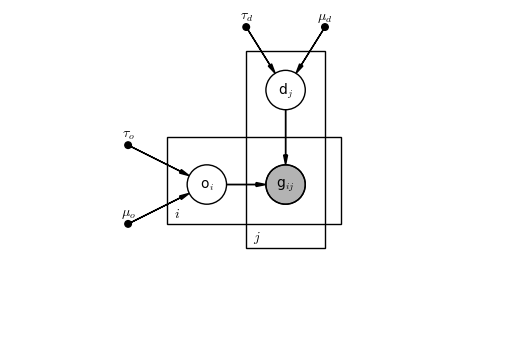

In [96]:
plot_model()

In [97]:
#top_club_ids
#home_goals_ # (home_team_id, away_team_id, goals_of_home_team)
#away_goals_ # (home_team_id, away_team_id, goals_of_away_team)

### Implementation with pymc

In [98]:
offence = [pymc.Normal("offence%i"%i, tau=1., mu=1.5) for i in top_club_ids]
defence = [pymc.Normal("defence%i"%i, tau=1., mu=0.) for i in top_club_ids]
 
home_goals = [pymc.Poisson("home_goals_%i_%i" % (heim,gast), 
                 observed=True, value=goals,
                 mu = pymc.Lambda("home_rate_%i_%i" % (heim, gast),
                 lambda o=offence[heim], d=defence[gast]: low if o-d<0. else o-d))  
              for i,(heim, gast, goals) in enumerate(home_goals_)]

away_goals = [pymc.Poisson("away_goals_%i_%i" % (heim,gast), 
                 observed=True, value=goals,
                 mu = pymc.Lambda("away_rate_%i_%i" % (heim, gast),
                 lambda o=offence[gast], d=defence[heim]: low if o-d<0. else o-d))  
              for i,(heim, gast, goals) in enumerate(away_goals_)]


In [99]:
#home_goals_


#### Sampling with pymc

In [100]:
mcmc = pymc.MCMC([offence, defence, home_goals, away_goals])
nb_samples=12000
burn=4000
mcmc.sample(nb_samples, burn=burn)#, thin=50)

 [-----------------100%-----------------] 12000 of 12000 complete in 129.6 sec

(array([   43.,    98.,   462.,   951.,  1917.,  2380.,  1318.,   691.,
          133.,     7.]),
 array([-0.77659262, -0.57566121, -0.37472979, -0.17379838,  0.02713303,
         0.22806444,  0.42899586,  0.62992727,  0.83085868,  1.03179009,
         1.23272151]),
 <a list of 10 Patch objects>)

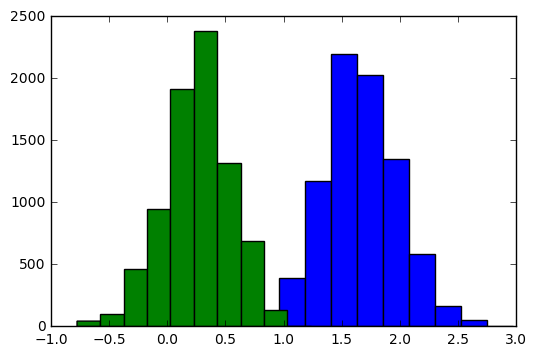

In [101]:
plt.hist(mcmc.trace("offence1")[:])
plt.hist(mcmc.trace("defence1")[:])


In [102]:
id_2_club = dict()
for i in top_club_ids: 
    id_2_club[i] = clubs["Name"][i]

In [103]:
id_2_club[6]

u'Borussia Dortmund'

In [104]:
#np.random.normal?

In [105]:
import scipy.stats
def print_sample_results(most_probable=True):
    for i in top_club_ids: 
        for j in top_club_ids:
            if i!=j:
                if most_probable:
                    k=0
                    h=nb_samples-burn
                else:
                    k = np.random.randint(low=0, high=nb_samples - burn)
                    h=k+1
                
                goals_home = np.random.poisson(diff)
                goals_away = np.random.poisson(d)
        
                print(clubs[clubs.index==i]["Name"][i], "-",)
                print(clubs[clubs.index==j]["Name"][j], " : ",)
                print(scipy.stats.mode(goals_home).mode[0], "-",)
                print(scipy.stats.mode(goals_away).mode[0])

In [106]:
def get_diff1(h,k,i,j):
    diff = mcmc.trace("offence%i"%i)[k:h] - mcmc.trace("defence%i"%j)[k:h]
    d = mcmc.trace("offence%i"%j)[k:h] - mcmc.trace("defence%i"%i)[k:h]
    return diff, d                   
             
#TODO clean code    
def print_sample_results(most_probable=True, diff_func=get_diff1, print_hook=None):
    p=0
    pp=0
    nb_p=0
    for i in top_club_ids: 
        for j in top_club_ids:
            if i!=j:
                if most_probable:
                    k=0
                    h=nb_samples - burn
                else:
                    k = np.random.randint(low=0, high=nb_samples - burn)
                    h = k+1
                    
                diff, d = get_diff1(h,k,i,j)
                diff[diff<0.]=low
                d[d<0.]=low
            
                
                goals_home = np.random.poisson(diff)
                goals_away = np.random.poisson(d)
        
                print clubs[clubs.index==i]["Name"][i], "-",
                print clubs[clubs.index==j]["Name"][j], "/ prediction: ",
                
                h_goals = scipy.stats.mode(goals_home).mode[0]
                print h_goals, #" (%2.1f)"%(diff.mean()),) 
                print"-",
                a_goals = scipy.stats.mode(goals_away).mode[0]
                print a_goals,
                game=top_games[((top_games['Heim']==i) & (top_games['Gast']==j))]
                predicted=(1 if h_goals>a_goals else 2 if h_goals<a_goals else 0)
                if not game.empty:
                    hg = game.Tore_Heim.values[0]
                    ag = game.Tore_Gast.values[0]
                    print " / result : ",hg, ":", ag,
                    result = (1 if hg>ag else 2 if hg<ag else 0)
                    nb_p +=1
                    if result == predicted:
                        p+=1  
                if print_hook:
                    pr = print_hook(k,h,i,j)
                    if result is not None and result == pr:
                        pp+=1
                print
                result=None
    return nb_p, p, pp

In [107]:
# sampling most probable results according to the model
#print_sample_results(most_probable=False)

# Sample results from a sample of the trace
nb_p, p, _ = print_sample_results(most_probable=True)

FC Bayern München - VfL Wolfsburg / prediction:  2 - 0  / result :  5 : 1
FC Bayern München - Borussia Mönchengladbach / prediction:  3 - 1
FC Bayern München - Bayer Leverkusen / prediction:  2 - 0  / result :  3 : 0
FC Bayern München - FC Augsburg / prediction:  2 - 0  / result :  2 : 1
FC Bayern München - FC Schalke 04 / prediction:  2 - 0
FC Bayern München - Borussia Dortmund / prediction:  2 - 1  / result :  5 : 1
FC Bayern München - 1899 Hoffenheim / prediction:  2 - 0
FC Bayern München - Eintracht Frankfurt / prediction:  2 - 0
FC Bayern München - SV Werder Bremen / prediction:  3 - 0
FC Bayern München - 1. FSV Mainz 05 / prediction:  2 - 0
FC Bayern München - 1. FC Köln / prediction:  2 - 0  / result :  4 : 0
FC Bayern München - Hannover 96 / prediction:  2 - 0
FC Bayern München - VfB Stuttgart / prediction:  3 - 0  / result :  4 : 0
FC Bayern München - Hertha BSC / prediction:  2 - 0  / result :  2 : 0
FC Bayern München - Hamburger SV / prediction:  2 - 0  / result :  5 : 0
FC 

In [108]:
print("train data accuracy", float(p)/nb_p)

('train data accuracy', 0.48366013071895425)


In [109]:
# mean of offence strength
for i in top_club_ids: 
    print clubs[clubs.index==i]["Name"][i], mcmc.trace("offence%i"%i)[:].mean()

FC Bayern München 2.64362337886
VfL Wolfsburg 1.66830219386
Borussia Mönchengladbach 2.13482201851
Bayer Leverkusen 1.43316135915
FC Augsburg 1.41090059891
FC Schalke 04 1.53743951054
Borussia Dortmund 2.66487893772
1899 Hoffenheim 1.32381644039
Eintracht Frankfurt 1.31989926406
SV Werder Bremen 1.1373055219
1. FSV Mainz 05 1.38491380354
1. FC Köln 1.21268313809
Hannover 96 1.29260194051
VfB Stuttgart 1.48863157783
Hertha BSC 1.58956380808
Hamburger SV 1.13526834011
FC Ingolstadt 04 0.785162624153
SV Darmstadt 98 1.12815519538


In [110]:
# mean of defence strength
for i in top_club_ids: 
    print clubs[clubs.index==i]["Name"][i], " ", mcmc.trace("defence%i"%i)[:].mean()

FC Bayern München   0.919481231475
VfL Wolfsburg   0.261963251394
Borussia Mönchengladbach   -0.371791779582
Bayer Leverkusen   0.289913312863
FC Augsburg   -0.0605317842042
FC Schalke 04   0.0891906155125
Borussia Dortmund   -0.00438041950434
1899 Hoffenheim   -0.0693759915371
Eintracht Frankfurt   -0.221794985704
SV Werder Bremen   -0.430636417976
1. FSV Mainz 05   -0.0116648463074
1. FC Köln   0.0906137164725
Hannover 96   -0.200810902409
VfB Stuttgart   -0.602802406243
Hertha BSC   0.472317736128
Hamburger SV   0.100358107185
FC Ingolstadt 04   0.33368196557
SV Darmstadt 98   -0.140650145562


#### Sampling histograms

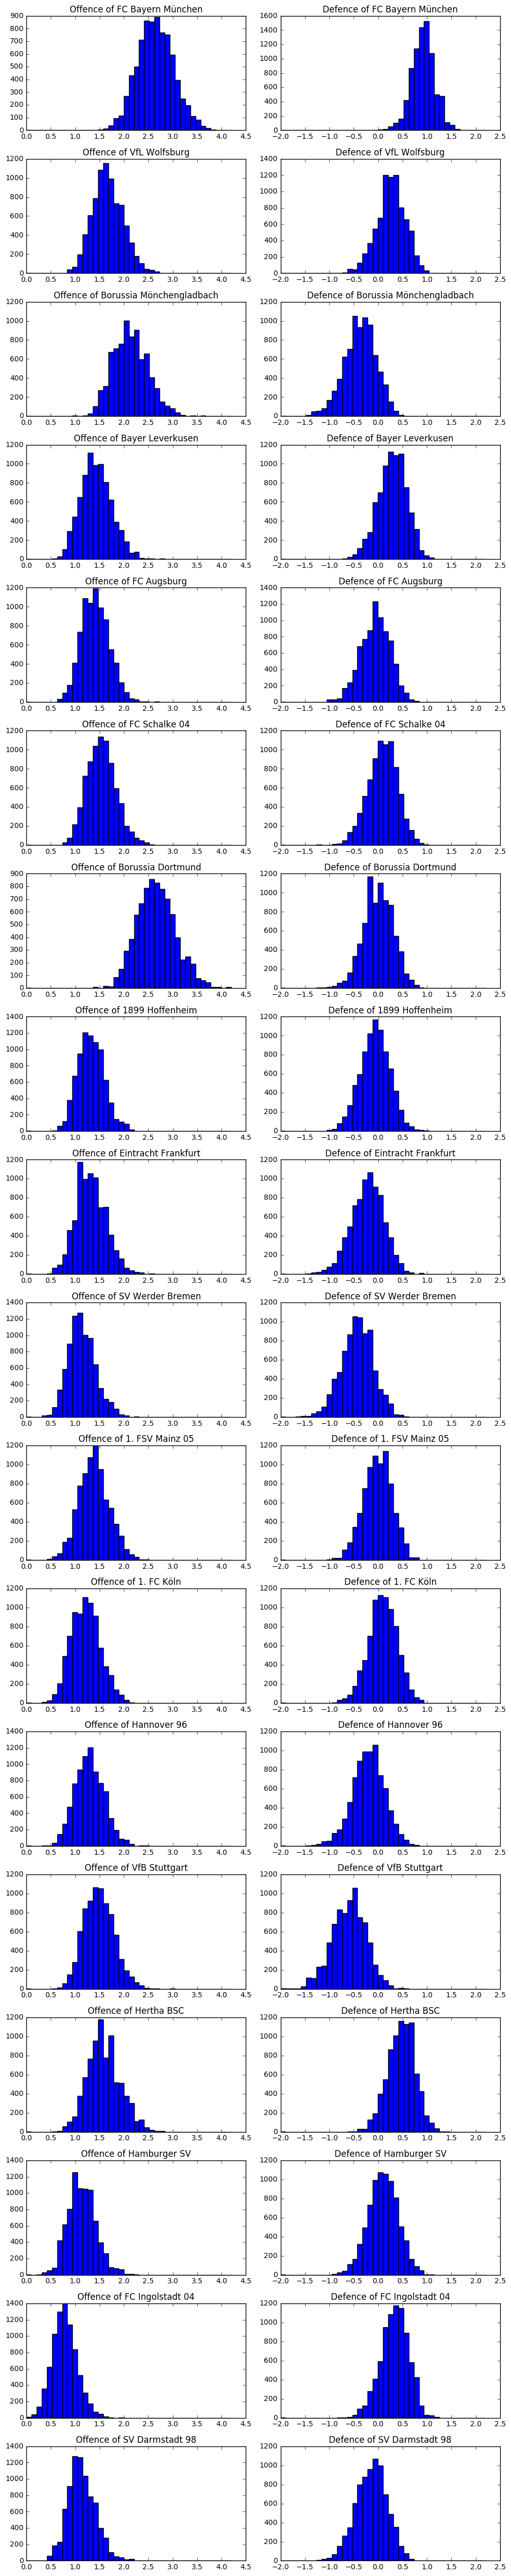

In [111]:
nb_clubs = top_club_ids.max() + 1
bins=40
fig, axes = plt.subplots(nrows=nb_clubs, ncols=2, figsize=(10, 50))

for i in top_club_ids: 
    title = "Offence of " + clubs[clubs.index==i]["Name"][i]
    axes[i, 0].set_title(title)
    axes[i, 0].hist(mcmc.trace("offence%i"%i)[:], bins=bins, range=(0,4.2))
    
    axes[i, 1].hist(mcmc.trace("defence%i"%i)[:], bins=bins, range=(-2.,2.2))
    title = "Defence of " + clubs[clubs.index==i]["Name"][i]
    axes[i, 1].set_title(title)

#fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

In [112]:
#toto_results_
"""Assignment prediction bundesliga
Write a function for the Bundesliga Preditor (into the ipython notebook) to compute the distribution how many goals team with id1 scores against team with id2.
def get_goal_distribution(...)
The function should return a numpy array with the probabilities, e.g.
> array([  7.52266366e-02,   1.87908528e-01,   2.41195214e-01,
     2.11872586e-01,   1.43138234e-01,   7.92529601e-02,
     3.74274244e-02,   1.54933669e-02,   5.73442687e-03,
     1.92632176e-03,   5.94202661e-04,   1.69885586e-04,
     4.53615301e-05,   1.13827229e-05,   2.69837689e-06,
     6.06977959e-07,   1.30043093e-07,   2.66221362e-08,
     5.22209646e-09,   9.83872176e-10])
The first entry is the probability that the team_1 scores no goals (here .52266366e-02).
The second entry is the probability that the team_1 scores one goal (here 1.87908528e-01).
..."""

'Assignment prediction bundesliga\nWrite a function for the Bundesliga Preditor (into the ipython notebook) to compute the distribution how many goals team with id1 scores against team with id2.\ndef get_goal_distribution(...)\nThe function should return a numpy array with the probabilities, e.g.\n> array([  7.52266366e-02,   1.87908528e-01,   2.41195214e-01,\n     2.11872586e-01,   1.43138234e-01,   7.92529601e-02,\n     3.74274244e-02,   1.54933669e-02,   5.73442687e-03,\n     1.92632176e-03,   5.94202661e-04,   1.69885586e-04,\n     4.53615301e-05,   1.13827229e-05,   2.69837689e-06,\n     6.06977959e-07,   1.30043093e-07,   2.66221362e-08,\n     5.22209646e-09,   9.83872176e-10])\nThe first entry is the probability that the team_1 scores no goals (here .52266366e-02).\nThe second entry is the probability that the team_1 scores one goal (here 1.87908528e-01).\n...'

In [113]:
def get_diffs(team_1, team_2):
    #TODO implement
    d1 = mcmc.trace("offence%i"%team_1)[:].mean() - mcmc.trace("defence%i"% team_2)[:].mean()
    d2 = mcmc.trace("offence%i"% team_2)[:].mean() - mcmc.trace("defence%i"%team_1)[:].mean()
    return d1, d2 

In [114]:
#d1, d2 = get_diffs(1, 4)

In [139]:
def get_goal_distribution(lamdba):
    k = np.arange(20)
    goal_diff = scipy.stats.poisson.pmf(k, lamdba) 
    return goal_diff


In [140]:
def plot_goal_diffs(team_1, team_2):
    
    bins=40
    (d1, d2) = get_diffs(team_1, team_2)
    
    goals_1 = get_goal_distribution(d1)
    goals_2 = get_goal_distribution(d2)
    
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(121)
    title = "Goals of " + clubs[clubs.index==team_1]["Name"][team_1]
    ax.set_title(title)
    _ = ax.plot(np.arange(0,20), goals_1, "b*")
    ax.set_xlim(-0.5, 8.5)
    
    ax = plt.subplot(122)
    title = "Goals of " + clubs[clubs.index==team_2]["Name"][team_2]
    ax.set_title(title)
    _ = ax.plot(np.arange(0,20), goals_2, "k*")
    ax.set_xlim(-0.5, 8.5)

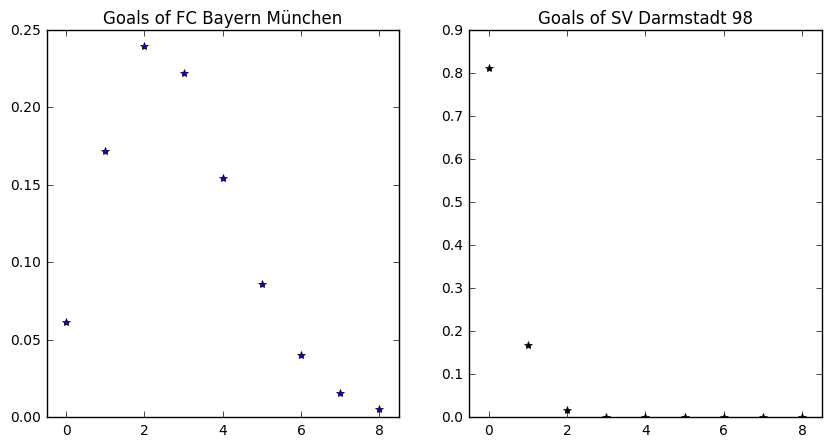

In [141]:
plot_goal_diffs(0, 17)

#### Exercise

To investigate the model sample from the model without using observed data. Adapt the prior to get senseful results.

#### Exercice: Extension of the model

Extend the model e.g. with
- home advantage
- take win/loose/draw into account
